Part II:
- loads the feature files for each snapshot from the features_csv folder
- perform a clustering algorithm on each snapshot and plot the results

In [1]:
import pandas as pd
import os

# Directory where the CSV files are stored
input_directory = "features_csv"

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(input_directory) if f.endswith(".csv")]

# Sort the CSV files based on the numeric part of the filename: 100ps, 200ps, .............., 2300ps
csv_files.sort(key=lambda x: int(os.path.splitext(x)[0]))

# Initialize an empty dictionary to store the DataFrames
df_dict = {}

# Loop through the sorted CSV files and load them into DataFrames
for csv_file in csv_files:
    # Extract the numeric part of the filename (e.g., "100" from "100.csv")
    numeric_part = os.path.splitext(csv_file)[0]
#     numeric_part = filename_without_extension
    
    # Load the CSV file into a DataFrame and use the numeric part as the key
    df_dict[numeric_part] = pd.read_csv(os.path.join(input_directory, csv_file))



In [2]:
df_dict

{'100':            ID         x         y          z        Q6  Nc_6  dist_from_c  \
 0       40501 -16.38540  -2.39567  -3.764020  0.345225    22    16.982003   
 1       40502 -16.31390  -3.99193   0.709113  0.353391    13    16.810166   
 2       40503 -16.28160  -1.16386  -1.674580  0.324974    12    16.408817   
 3       40504 -17.88830  -3.10669  -1.093870  0.288496    19    18.188990   
 4       40505 -12.69680   3.65584  -8.093180  0.255736    12    15.494304   
 ...       ...       ...       ...        ...       ...   ...          ...   
 60745  101246  32.05200   7.79728  23.053200  0.350000     1    40.243985   
 60746  101247   9.56576  40.49870 -50.210400  0.231831     2    65.212980   
 60747  101248   7.71312 -39.15240  43.590500  0.305441     2    59.097668   
 60748  101249  14.70350 -15.06040 -20.739100  0.266667     0    29.548584   
 60749  101250  44.35910  10.24520 -49.726700  0.210090     0    67.419868   
 
            disp      d_5NN  N_N  
 0      0.695387   2

- df_dict is a dictionary with keys in increasing order of snapshot time from 100-2700
- To confirm the order you may run
   - df_dict.keys()
   
__Let us work out the clustering algorithm now__

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import pyprind
import numpy as np 
prog_bar = pyprind.ProgBar(len(df_dict.keys()))

n_atoms_per_cluster, avg_disp_per_cluster, avg_Nc_per_cluster = [], [], []
mean_Q6_snap, mean_Nc_snap, mean_disp_snap = [],[],[]
inertia, cc_I, cc_II = [],[],[]
ct_Nc_gt_10 = []

for identifier, df in df_dict.items():
    X = df
    rx,ry,rz = X['x'], X['y'], X['z']
    X_mat = X[['Q6','Nc_6','disp','N_N']].values
    
    ct_Nc_gt_10.append(len(X_mat[X_mat[:,3]>10]))
    mean_Q6_snap.append(np.mean(X_mat[:,0]))
    mean_Nc_snap.append(np.mean(X_mat[:,1]))
    mean_disp_snap.append(np.mean(X_mat[:,2]))
    
    sc = StandardScaler()
    sc.fit(X_mat)
    X_std = sc.transform(X_mat)
    
    km = KMeans(n_clusters=2,  init='k-means++', n_init=100, max_iter=100000, tol=1e-10, random_state=0)
    y_km = km.fit_predict(X_std)    

    cc_I.append(km.cluster_centers_[0,:])
    cc_II.append(km.cluster_centers_[1,:])  
    
    n_c = 2
    # Calculate the mean value of the 2nd column for each cluster
    avg_2nd_col = [np.mean(X_mat[km.labels_ == i, 1]) for i in range(n_c)]

# Determine the cluster with the larger mean value of the 2nd column as label 1, and the other as label 0
    larger_avg_c = np.argmax(avg_2nd_col)
    c_labels = [1 if i == larger_avg_c else 0 for i in range(n_c)]

# Map cluster labels to the original KMeans labels
    final_labels = [c_labels[km_label] for km_label in km.labels_]
# Add the final cluster labels to the DataFrame
    df['Cluster_Labels'] = final_labels
    n_atoms_per_cluster.append([final_labels.count(1), final_labels.count(0)])
#     print(sorted_chunks[ind][sorted_chunks[ind]['Cluster_Labels'] == 0]['disp'].mean())
#     print(sorted_chunks[ind][sorted_chunks[ind]['Cluster_Labels'] == 1]['disp'].mean())

# Add average displacment per cluster
    filtered_df0 = df[df['Cluster_Labels'] == 0]
    filtered_df1 = df[df['Cluster_Labels'] == 1]
    
    avg_disp_per_cluster.append([filtered_df1['disp'].mean(), filtered_df0['disp'].mean()])
    avg_Nc_per_cluster.append([filtered_df1['Nc_6'].mean(), filtered_df0['Nc_6'].mean()])

    prog_bar.update()    


/home/rat42/anaconda3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
0% [###########################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:35


In [4]:
avg_Nc_per_cluster

[[11.594202898550725, 2.1260553569330445],
 [11.895752895752896, 2.1447481288369357],
 [11.064341085271318, 2.142902791792802],
 [11.994835377663009, 2.126180301008429],
 [11.923761825264329, 2.153817447797398],
 [12.057155921353452, 2.1523999795092466],
 [11.870788743559254, 2.139900733336768],
 [12.528415506210012, 2.17113937995972],
 [12.002710945442223, 2.1613349711932734],
 [11.681752248331883, 2.145891140079926],
 [12.323772915434654, 2.1656498396318504],
 [12.513678618857902, 2.1735193471966308],
 [11.650073206442167, 2.171838593518322],
 [11.951300728407908, 2.156385735990705],
 [11.92564696794129, 2.154016411142302],
 [11.870350500715308, 2.2003517168860363],
 [12.085392217418159, 2.16228765154586],
 [12.126370083816893, 2.171903009717898],
 [11.978428701180745, 2.1764083015671325],
 [11.947886623570364, 2.2061741789131077],
 [12.619757852254782, 2.2126560220457123],
 [12.012577178138578, 2.2077428565430077],
 [12.328846552081176, 2.225298834922076],
 [12.087922943936775, 2.22

In [5]:
n_atoms_per_cluster

[[1173, 59577],
 [1295, 59455],
 [1290, 59460],
 [1549, 59201],
 [1797, 58953],
 [2187, 58563],
 [2523, 58227],
 [2657, 58093],
 [2951, 57799],
 [3447, 57303],
 [3382, 57368],
 [3765, 56985],
 [4098, 56652],
 [4805, 55945],
 [5178, 55572],
 [5592, 55158],
 [6476, 54274],
 [7755, 52995],
 [8808, 51942],
 [10055, 50695],
 [11398, 49352],
 [13119, 47631],
 [14487, 46263],
 [16196, 44554],
 [17950, 42800],
 [20140, 40610],
 [22543, 38207]]

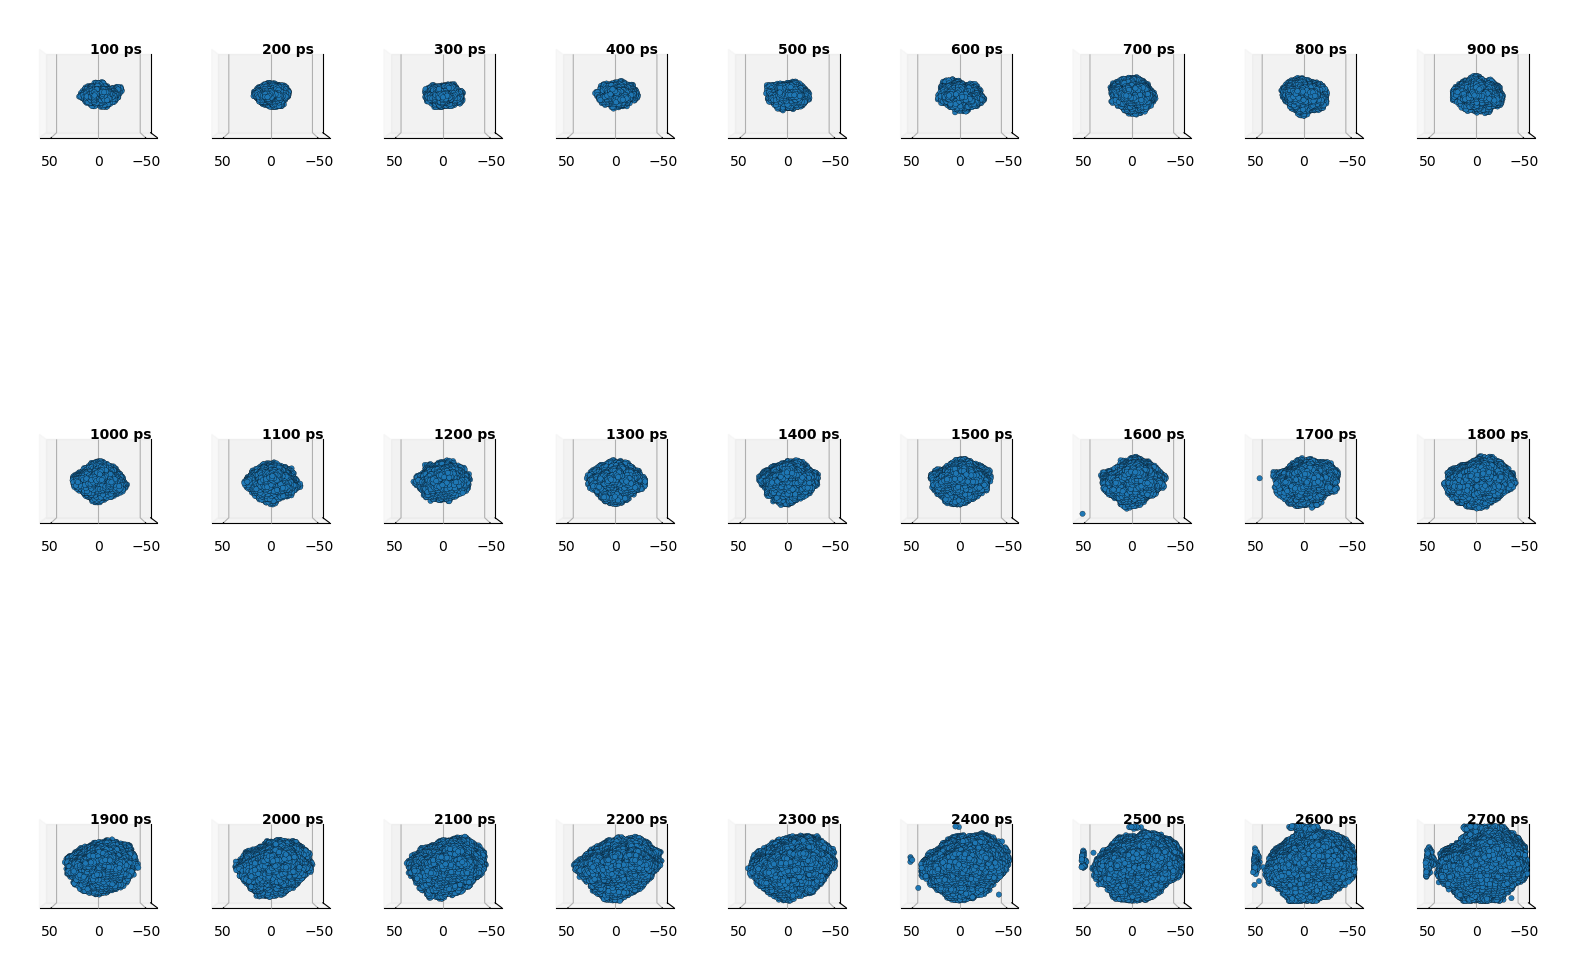

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plots


fig = plt.figure(figsize=(20,15))
rows = 3
cols = int(len(df_dict)/rows)
gs = gridspec.GridSpec(rows, cols, wspace=0.0005, hspace=0.0005)

# for ind in range(len(df_dict.keys())):
ind = 0 
for identifier, df in df_dict.items():
    X = df
    rx,ry,rz = np.asarray(X['x']), np.asarray(X['y']), np.asarray(X['z'])
    indices = []
    for ct_ in range(len(X)):
        if X['Cluster_Labels'].iloc[ct_] == 1:
            indices.append(ct_)
    selected_rows = X.iloc[indices]
    
    
#     if ind== 19:
#         selected_rows[['x','y','z']].to_csv('pred_crystals_2000ps.xyz', sep='\t', header=None, index=None)

#         print(selected_rows[['Q6','Nc_6','disp','N_N']])

    x_slice, y_slice, z_slice = [rx[i] for i in indices], [ry[i] for i in indices],[rz[i] for i in indices]
    ax = fig.add_subplot(gs[ind//cols, ind%cols], projection='3d')
    ax.scatter(x_slice, y_slice, z_slice, s=15.0, linewidth=0.2, alpha=1.0,edgecolor='k');
    
    ax.view_init(elev=0, azim=90, roll=0)
    ax.text(10.0, 0.0, 60.0, f'{(ind+1)*100} ps', color='k', fontsize=10, fontweight='bold')
    ax.set_xlim(-60,60)
    ax.set_ylim(-60,60)
    ax.set_zlim(-60,60)
#     ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ind += 1
plt.savefig("crystal_Ox_cluster.png",dpi=400)
# plt.tight_layout()
plt.show()


In [7]:
NAT = len(df_dict['100'])

In [8]:
len(avg_Nc_per_cluster)

27

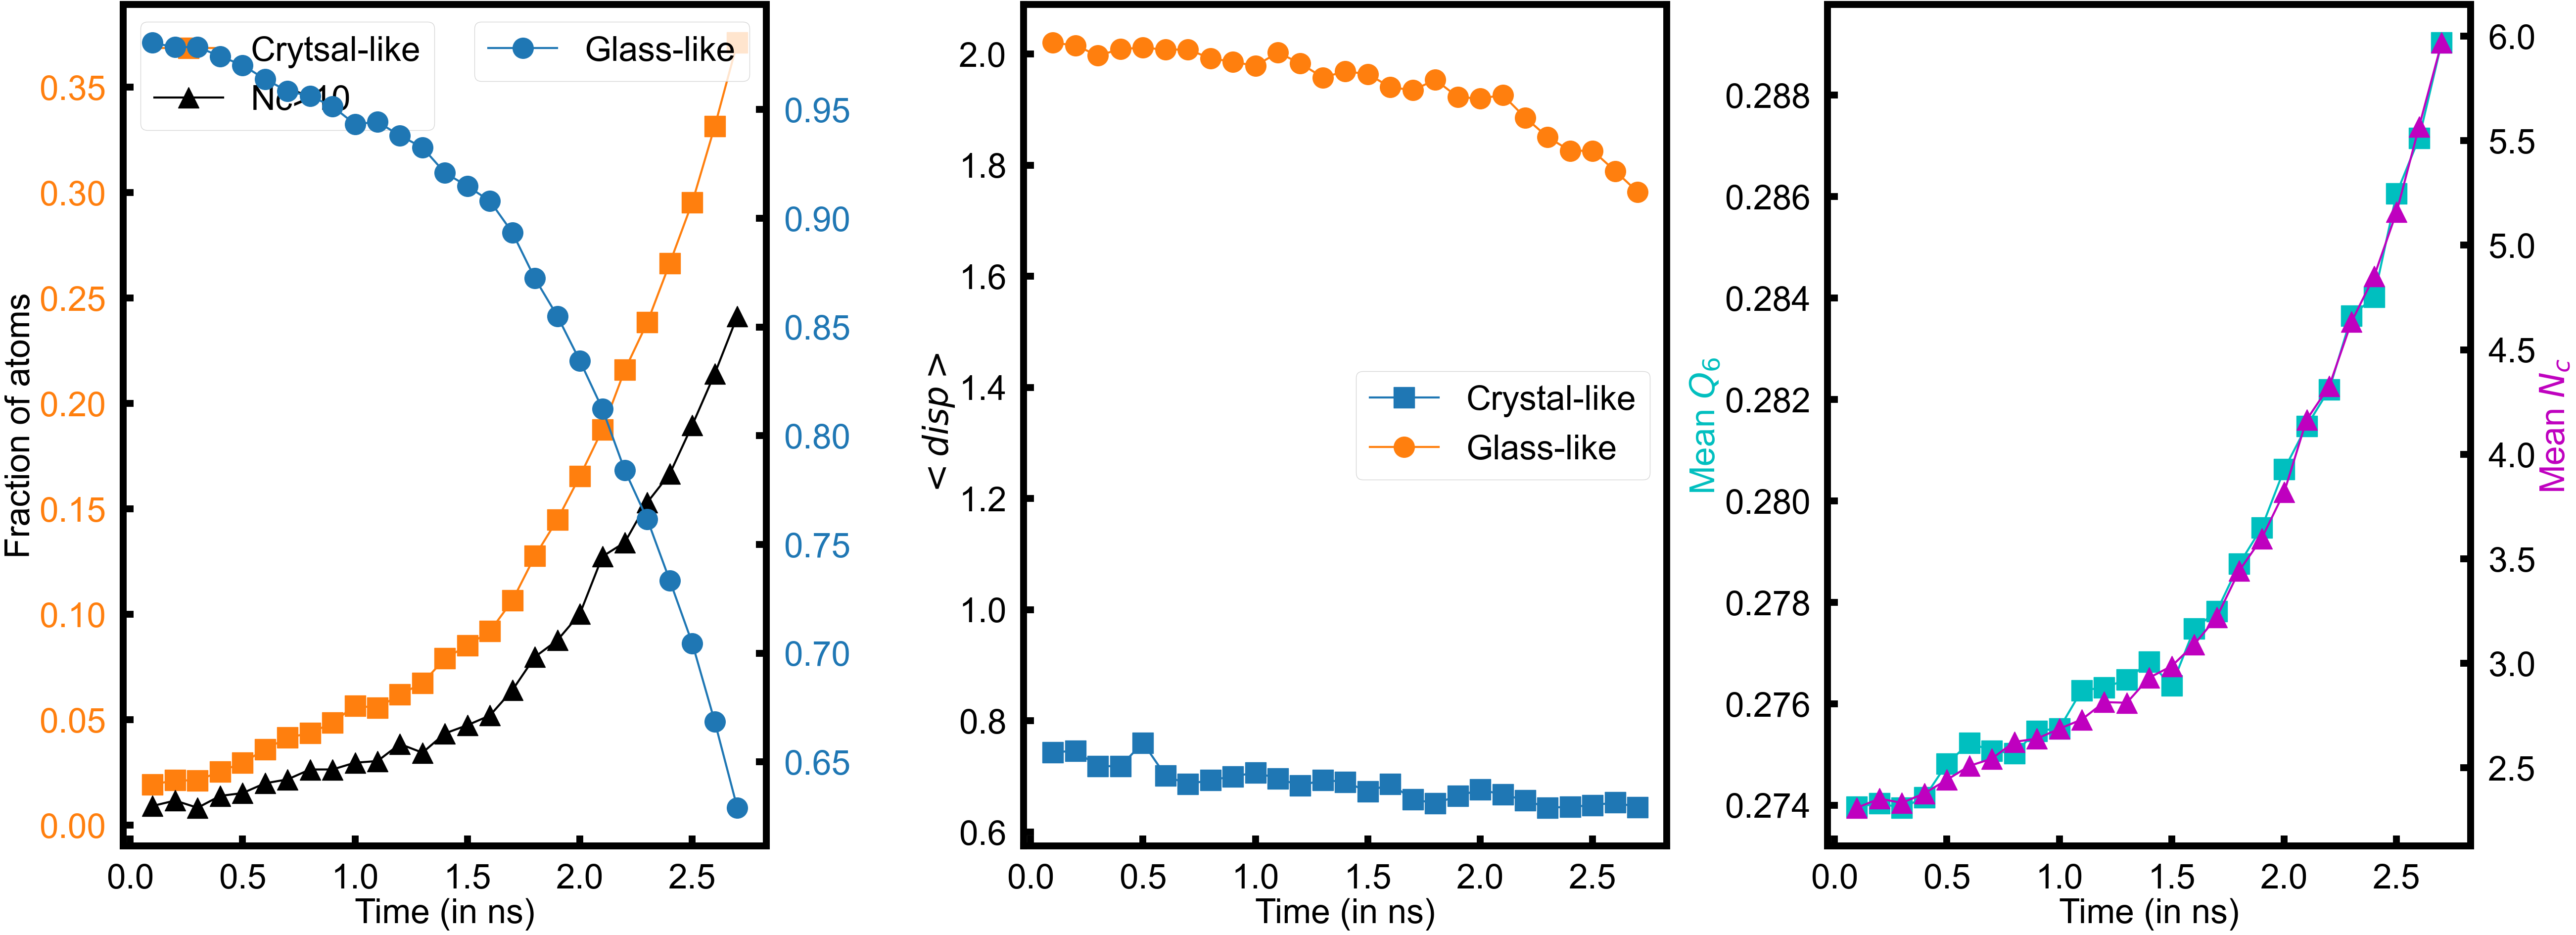

In [11]:
n_atoms_per_cluster = np.asarray(n_atoms_per_cluster)
avg_disp_per_cluster = np.asarray(avg_disp_per_cluster)

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 50
plt.rcParams['axes.labelsize'] = 50
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 75
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['xtick.labelsize'] =50
plt.rcParams['ytick.labelsize'] =50
plt.rcParams['lines.linewidth']=3.0
plt.rcParams['figure.figsize'] = 65,20
plt.rcParams['lines.markersize']=30.0
plt.rcParams['axes.linewidth'] =10

plt.rcParams['xtick.major.size']=15
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.major.width']=10.0

plt.rcParams['ytick.major.size']=15
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=10.0

plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'


left,bottom,width,height = 0.04,0.04,0.20,0.85
rect_one = [left, bottom, width, height]
rect_two= [left+width+0.08, bottom, width, height]            
rect_three= [left+2*width+0.13, bottom, width, height]            

one_plot = plt.axes(rect_one)
two_plot = plt.axes(rect_two)
three_plot = plt.axes(rect_three)


time_vals = np.linspace(0.1, 0.1*len(avg_Nc_per_cluster), len(avg_Nc_per_cluster))

one_plot.plot(time_vals,[i/NAT for i in n_atoms_per_cluster[:,0]], marker='s', label='Crytsal-like', color='#ff7f0e')
one_plot.plot(time_vals,[i/NAT for i in ct_Nc_gt_10], marker='^', label='Nc>10', color='k')
one_twin = one_plot.twinx()
one_twin.plot(time_vals,[i/NAT for i in n_atoms_per_cluster[:,1]], marker='o', label='Glass-like', color='#1f77b4')
# one_plot.plot(time_vals,ct_Nc_gt_10, marker='^',lw=0.0, color='red')
one_plot.set_xlabel('Time (in ns)')
one_plot.set_ylabel('Fraction of atoms')

two_plot.plot(time_vals,avg_disp_per_cluster[:,0], marker='s', label='Crystal-like')
two_plot.plot(time_vals,avg_disp_per_cluster[:,1], marker='o', label='Glass-like')
two_plot.set_xlabel('Time (in ns)')
two_plot.set_ylabel('$<disp>$')

three_plot.plot(time_vals,mean_Q6_snap, marker='s', color='c')
three_twin = three_plot.twinx()
three_twin.plot(time_vals,mean_Nc_snap, marker='^', color='m')

three_plot.set_xlabel('Time (in ns)')
three_plot.set_ylabel('Mean $Q_6$', color='c')
three_twin.set_ylabel('Mean $N_c$', color='m')
# three_plot.set_ylim(0.271,0.303)

one_plot.legend(loc='best')
one_twin.legend(loc='best')
one_twin.yaxis.set_tick_params(labelcolor='#1f77b4')  # Set the color to red
one_plot.yaxis.set_tick_params(labelcolor='#ff7f0e')  # Set the color to red
# one_plot.yticklabels(color='#1f77b4')
two_plot.legend()

# plt.savefig("f_time_evol.pdf",dpi=1500, bbox_inches="tight")
plt.savefig("f_time_evol.png",dpi=500, bbox_inches="tight")
plt.show()

In [12]:
np.savetxt("c_size_evol.txt", n_atoms_per_cluster, delimiter='\t', fmt='%d')